# Лабораторная работа 4. Часть 2. Рекомендательные системы.



Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 8 баллов. Сдавать задание после указанного в lk срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).



## Знакомство с данными

### Рекеомендация организаций, которые получат высокий отзыв от пользователя, когда он гостит в чужом для себя городе

Эта лабораторная работа про задачу из соревнования

https://contest.yandex.ru/contest/36927/problems/


**(1 балла) Задание 1.** Знакомство с данными.

В первую очередь нам понадобятся данные по __пользователям__ (в терминах recsys -- users), __организациям__ (в терминах recsys -- items) и сами __отзывы__ (в терминах recsys -- ratings или explicit feedback). 

На основании этих данных можно будет проводить базовый анализ методами колаборативной фильтрации.

  * Опишите, насколько активно пользователи оставляют отзывы, насколько активно организации получают отзывы.
  * Предложите стратегии фильтрации данных.
  


Во вторую очередь нас будут интересовать атрибуты организаций: aspects, features, rubrics.
Проанализируйте эти таблицы. Какие признаки для описания организаций и пользователей из них можно извлечь?


In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
!cp drive/MyDrive/Colab\ Notebooks/ML-2/Lab\ 4/2021_sem3_comp_1_data.zip 2021_sem3_comp_1_data.zip

In [3]:
!unzip 2021_sem3_comp_1_data.zip

Archive:  2021_sem3_comp_1_data.zip
   creating: data/
  inflating: data/aspects.csv        
  inflating: data/features.csv       
  inflating: data/organisations.csv  
  inflating: data/reviews.csv        
  inflating: data/rubrics.csv        
  inflating: data/test_users.csv     
  inflating: data/users.csv          


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')

### Users/Items/Reviews

In [5]:
users = pd.read_csv('data/users.csv')
assert users['user_id'].nunique() == users.shape[0]
assert 0 == users.isna().sum().sum()
print(users.shape)
print(users['city'].value_counts())
users.head(2)

(1393008, 2)
msk    1014244
spb     378764
Name: city, dtype: int64


,user_id,city
0,12735004856856244189,msk
1,13776338520332531455,msk


In [6]:
test_users = pd.read_csv('data/test_users.csv')
test_users.head(2)

,user_id
0,11859048046981233908
1,15587804372050325574


In [7]:
items = pd.read_csv('data/organisations.csv')
assert items['org_id'].nunique() == items.shape[0]
print(items.shape)
items['average_bill'] = pd.to_numeric(items['average_bill'], errors='coerce')
items.head(2)

(68339, 6)


,org_id,city,average_bill,rating,rubrics_id,features_id
0,15903868628669802651,msk,1500.0,4.270968,30776 30774,3501685156 3501779478 20422 3502045016 3502045...
1,16076540698036998306,msk,500.0,4.375000,30771,1509 1082283206 273469383 10462 11617 35017794...


In [8]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68339 entries, 0 to 68338
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   org_id        68339 non-null  uint64 
 1   city          68339 non-null  object 
 2   average_bill  32778 non-null  float64
 3   rating        54608 non-null  float64
 4   rubrics_id    68339 non-null  object 
 5   features_id   57290 non-null  object 
dtypes: float64(2), object(3), uint64(1)
memory usage: 3.1+ MB


Max average_bill: 7502000.0


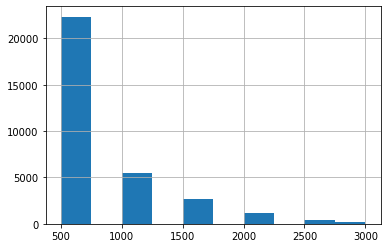

In [9]:
print('Max average_bill:', items['average_bill'].max())
items.loc[items['average_bill'] < items['average_bill'].quantile(0.99)]['average_bill'].hist()

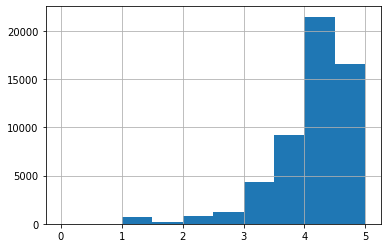

In [10]:
items['rating'].hist()

In [11]:
reviews = pd.read_csv('data/reviews.csv', low_memory=False)
print(reviews.shape)
reviews.head(2)

(4129696, 5)


,user_id,org_id,rating,ts,aspects
0,5969205021826098131,15999570556361329805,1.0,279,NaN
1,11419028914633614269,15999570556361329805,1.0,391,NaN


In [12]:
reviews.isna().sum()

user_id          0
org_id           0
rating        1362
ts               0
aspects    3407084
dtype: int64

#### Насколько активно пользователи оставляют отзывы

Всего пользователей: 1393008
Всего пользователей, оставивших отзыв: 1393008
Пользователей с 1 отзывом: 716891
Пользователей с <5 отзывами: 1173294
Пользователей с <10 отзывами: 1321823
Пользователей с <20 отзывами: 1375643


user_id
9252858208026838922     611
1609942953487295332     447
8313742073667600029     405
16750291430328002048    368
6505126316769964142     356
Name: rating, dtype: int64

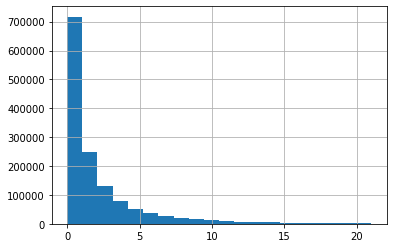

In [13]:
reviews_per_user = reviews.groupby('user_id')['rating'].count()

# для визуализации ограничим хвост 0.99 квантилем
reviews_per_user[reviews_per_user < reviews_per_user.quantile(0.99)].hist(bins=20)

print('Всего пользователей:', users['user_id'].nunique())
print('Всего пользователей, оставивших отзыв:', reviews_per_user.shape[0])
print('Пользователей с 1 отзывом:', reviews_per_user[reviews_per_user == 1].shape[0])
print('Пользователей с <5 отзывами:', reviews_per_user[reviews_per_user < 5].shape[0])
print('Пользователей с <10 отзывами:', reviews_per_user[reviews_per_user < 10].shape[0])
print('Пользователей с <20 отзывами:', reviews_per_user[reviews_per_user < 20].shape[0])

reviews_per_user.sort_values(ascending=False).head(5)

* Половина пользователей (~51%) оставили ровно 1 отзыв
* Большинство пользователей (~84%) оставили не более 5 отзывов
* Хвост распределения длинный - есть пользователи, оставившие 400-600 отзывов

#### Насколько активно организации получают отзывы

Всего организаций: 68339
Всего организаций, получивших отзыв: 68339
Организаций с 1 отзывом: 13389
Организаций с <5 отзывами: 26442
Организаций с <10 отзывами: 36778
Организаций с <50 отзывами: 54967
Организаций с <100 отзывами: 60088


org_id
15120040193672648022    61498
11006800892303205642    53983
6275604663748314015     27611
9051738536823896242     23177
8578061102249595977     21076
Name: rating, dtype: int64

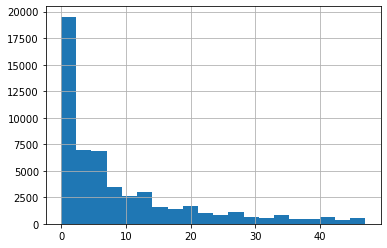

In [14]:
reviews_per_org = reviews.groupby('org_id')['rating'].count()

# для визуализации ограничим хвост 0.80 квантилем
reviews_per_org[reviews_per_org < reviews_per_org.quantile(0.8)].hist(bins=20)

print('Всего организаций:', items['org_id'].nunique())
print('Всего организаций, получивших отзыв:', reviews_per_org.shape[0])
print('Организаций с 1 отзывом:', reviews_per_org[reviews_per_org == 1].shape[0])
print('Организаций с <5 отзывами:', reviews_per_org[reviews_per_org < 5].shape[0])
print('Организаций с <10 отзывами:', reviews_per_org[reviews_per_org < 10].shape[0])
print('Организаций с <50 отзывами:', reviews_per_org[reviews_per_org < 50].shape[0])
print('Организаций с <100 отзывами:', reviews_per_org[reviews_per_org < 100].shape[0])

reviews_per_org.sort_values(ascending=False).head(5)

* Организаций с ровно 1 отзывом немного (\~20%), с <5 отзывами в 2 раза больше (~39%)
* У половины (~53%) организаций не более 10 отзывов
* У ~20% организаций не более 50 отзывов
* У большинства организаций (~88%) отзывов не более 100
* Хвост распределения длинный - есть популярные организации с 50-60 тыс. отзывов

#### Стратегия фильтрации данных

Отфильтруем пользователей и организации, о которых мы мало знаем, плюс для ускорения вычислений:
* пользователи с 5 и более отзывами (оставим ~16% от исходной выборки)
* организации с менее, чем 50 отзывами (оставим ~20% от исходной выборки)

In [15]:
def perc_drop(before, after):
    return f"(-{int(100*((before - after)/before))}%)"

users_filtered = users.loc[users['user_id'].isin(reviews_per_user[reviews_per_user >= 5].index)]
items_filtered = items.loc[items['org_id'].isin(reviews_per_org[reviews_per_org >= 50].index)]
reviews_filtered = reviews.loc[(reviews['user_id'].isin(users_filtered['user_id'])) & 
                               (reviews['org_id'].isin(items_filtered['org_id']))]

print(f"Users: {users['user_id'].nunique()} -> {users_filtered['user_id'].nunique()}", 
      perc_drop(users['user_id'].nunique(), users_filtered['user_id'].nunique()))
print(f"Items: {items['org_id'].nunique()} -> {items_filtered['org_id'].nunique()}", 
      perc_drop(items['org_id'].nunique(), items_filtered['org_id'].nunique()))
print(f"Reviews: {reviews.shape[0]} -> {reviews_filtered.shape[0]}", 
      perc_drop(reviews.shape[0], reviews_filtered.shape[0]))

Users: 1393008 -> 219714 (-84%)
Items: 68339 -> 13372 (-80%)
Reviews: 4129696 -> 1945738 (-52%)


#### Aspects/Features/Rubrics

In [16]:
aspects = pd.read_csv('data/aspects.csv')
aspects.head(2)

,aspect_id,aspect_name
0,1,Бургеры
1,2,Чистота


In [17]:
assert aspects.shape[0] == aspects['aspect_id'].nunique()
print(f'Всего аспектов: {aspects.shape[0]}')

Всего аспектов: 243


In [18]:
features = pd.read_csv('data/features.csv')
features.head(2)

,feature_id,feature_name
0,1,prepress_and_post_printing_processing
1,40,products


In [19]:
assert features.shape[0] == features['feature_id'].nunique()
print(f'Всего фичей: {features.shape[0]}')

Всего фичей: 1006


In [20]:
rubrics = pd.read_csv('data/rubrics.csv')
rubrics.head(2)

,rubric_id,rubric_name
0,30519,"Булочная, пекарня"
1,30770,"Бар, паб"


In [21]:
assert rubrics.shape[0] == rubrics['rubric_id'].nunique()
print(f'Всего рубрик: {rubrics.shape[0]}')

Всего рубрик: 15


#### Идеи признаков для описания организаций и пользователей из Aspects/Features/Rubrics

Описание организации:
* частота оценок организации аспектами, их немного (243), можно и по 1 фиче на кол-во данного аспекта, либо по самым популярным
* что ценят, а что не любят в заведении - высокие оценки или низкие + какие аспекты, категориальные признаками вида "топ аспект среди низких/высоких оценок"
* векторизованное представление (эмбеддинг) словестного описания фичей
* уникальность описания фичами, как много пересечений в словах фичей с другими организациями
* рубрика (их мало, 15), как категориальный признак организации
* популярность рубрики - номер в топе наиболее численных рубрик, т.е. насколько организация редкая/распространенная
* город организации - категориальный признак (можно ограничить до топ самых популярных, чтобы не делать очень много категорий)
* средний чек - as-is можно взять фичей

Описание пользователей:
* город пользователя - категориальный признак (можно ограничить до топ самых популярных)
* наиболее популярные аспекты/рубрики среди высокого/низкого рейтинга (или средние оценки в разрезе аспектов/рубрик), то есть что пользователь ценит и с этими аспектами ему лучше порекомендовать другие места, а что он терпеть не может и тогда ему другие такие месте нельзя предлагать
* объединение словестного описания фичей все оцененных организаций пользователем создает собирательный образ вкусов человека, можно сделать из этого эмбеддинг, отражающий вкусы человека 
* набор уникальных слов/тегов среди фичей оцененных организаций можно использовать для пересечения с описаниями других организаций (например, мерой Жаккара по словам/N-граммам) и находить максимально похожее, либо признак сделать создав эмбеддинг на этот текст фичей, или что-то проще (tf-idf, мешок слов)
* аналогично с рубриками, можно тоже рекомендовать схожую организацию не только по фичам, но и в рамках рубрик, то есть более точно

**(1 балла) Задание 2.** Организация валидации.

Как вы помните, обучающее множество собрано за X = 1277 дней, тестовое множество – за последующие Y = 107 дней.

Следовательно нам необходимо организовать у себя валидацию схожим образом.
Раз мы будем еще и осуществлять выбор моделей, то следует произвести расщепление по времнеи на 3 группы train validation и holdout.

Как уже говорилось на семинаре, для повышения качества локальной валидации, можно сделать скользящую валидацию. В самой лабораторной работе мы так делат не будем, но для конкурса имейте это в виду.

#### Разобьет по ts на 3 группы в соотношении 60/20/20

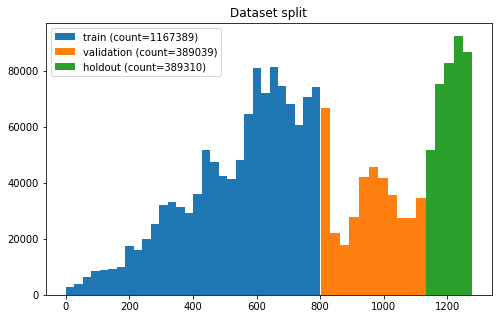

In [22]:
quant_1 = reviews_filtered['ts'].quantile(0.6)
quant_2 = reviews_filtered['ts'].quantile(0.8)

train = reviews_filtered.loc[reviews_filtered['ts'] < quant_1]
validation = reviews_filtered.loc[(reviews_filtered['ts'] >= quant_1) & (reviews_filtered['ts'] < quant_2)]
holdout = reviews_filtered.loc[reviews_filtered['ts'] >= quant_2]

plt.figure(figsize=(8,5))
plt.hist(train['ts'], bins=30, label=f'train (count={train.shape[0]})')
plt.hist(validation['ts'], bins=11, label=f'validation (count={validation.shape[0]})')
plt.hist(holdout['ts'], bins=5, label=f'holdout (count={holdout.shape[0]})')
plt.title('Dataset split')
plt.legend()
plt.show()

#### Для репрезентативного расчета метрик качества, для validation и holdout оставим только тех пользователей, у которых 5 и более оценок и возьмем первые 5 из них, а также удалим холодных пользователей (нет в трейне, но есть в тесте)

In [23]:
def clean_validation_holdout(validation, holdout, train_users):
    def clean(df):
        counts = df.groupby('user_id')['rating'].count()
        df = df.loc[df['user_id'].isin(counts[counts >= 5].index)]
        df['rank'] = df.groupby('user_id')['ts'].rank(method="first", ascending=True)
        df = df.loc[df['rank'] <= 5].drop(columns=['rank'])

        # удалим холодных пользователей
        df = df.loc[df['user_id'].isin(train_users)]
        return df
    
    val, hold = clean(validation), clean(holdout)
    print(f"Validation: {validation.shape[0]} -> {val.shape[0]}", 
      perc_drop(validation.shape[0], val.shape[0]))
    print(f"Holdout: {holdout.shape[0]} -> {hold.shape[0]}", 
      perc_drop(holdout.shape[0], hold.shape[0]))
    
    return val, hold

In [24]:
val, hold = clean_validation_holdout(validation, holdout, train['user_id'].unique())

Validation: 389039 -> 79325 (-79%)
Holdout: 389310 -> 61485 (-84%)


#### Почистим не нужные df

In [25]:
# del users
# del items
# del reviews
# del reviews_filtered

**(0.5 балла) Задание 3.** Базовые решения.

Сделаем базовые решения:
  * Для каждого пользователя выдаём 20 случайных организаций (в неродном городе)
  * Для каждого пользователя выдаём самые популярные организации в неродном городе

In [26]:
def get_n_random_rec(items, city, n=20):
    return list(items.loc[items['city'] != city]['org_id'].sample(n))

# определим "самые популярные", как "отзывов > 1000 и наибольший рейтинг"
def get_most_popular(reviews_per_org, items, city, n=20):
    items_enough_reviews = reviews_per_org[reviews_per_org > 1000].index
    items_sorted = items.sort_values(by=['city', 'rating'], ascending=[True, False])
    most_popular = items_sorted.loc[items_sorted['org_id'].isin(items_enough_reviews)].groupby('city').head(20)\
        [['city', 'org_id', 'rating']].reset_index(drop=True)
    return list(most_popular.loc[most_popular['city'] != city]['org_id'])

**(1.0 балла) Задание 4.** Метрики качества.

Напомним, что у нас бинарная релевантность на основе оценки вычисляется как предикат **оценка больше, чем 3**.

Реализуйте набор метрик качества (можете оборачивать внешние пакеты):
    * MNAP@20 (как в описании соревнования)
    * HitRate (= 1, если среди рекомендаций есть хотя бы одна релевантная и 0 иначе)
    * MRR@20 (обратная позиция первой релевантной рекомендации из списка рекомендаций длины K. )
    * Coverage (доля item-ов, учитываемых в рекомендациях)
    * Surprisal (см. ниже) 


### Surprisal
Посмотирм, насколько наши рекомендации хороши с точки зрения новизны для пользователя, в качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

Будем рассматривать собственную информацию item-а как меру его новизны.

$$selfInformation(i) = -\log_2 \frac{|u_i|}{|N|}$$, 
где 
$i$ - объект, $|N|$ - число взаимодействий в обучающей выборке,  $|u_i|$ - число пользователей, взаимодействовавших с объектом в обучающей выборке.

После подсчета собственной информации усредним значения собственной информации в рекомендациях пользователя.

Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u)@k = \frac{1}{k \cdot log_2 N} \sum_{j = 1}^{k}selfInformation(i_{u,j})$$

где $i_{u,j}$ это j-й объект, который мы порекомендововали пользователю.

Получившаяся метрика похожа на энтропию Шеннона:
$$H = - K \sum_{i\in R}{p_i log p_i}$$


Результа усредним по пользователям.

### Что нужно сделать
    
  * Создайте функцию, которая генерирует словарь с метриками, по предоставленному решению.

  * Оцените baseline-решения на валидации.

#### Реализуем метрику MNAP@20 и проверим ее на небольшом датасете

In [27]:
def MNAP_K(df_, k=20):
    '''
    df: user_id | pred_list | gt_list | gt_rating
    Для каждого юзера все ground truth из другого города
    '''
    df = df_.copy()
    U = df.shape[0]
    
    def r_u(pred_list, gt_list, gt_rating):
        return [int(gt_rating[gt_list.index(pred_list[i])] >= 4) 
                         if pred in gt_list else 0 
                         for i, pred in enumerate(pred_list)]

    df['n_u'] = df.apply(lambda x: sum(np.array(x['gt_rating']) >= 4), axis=1)
    df['r_u'] = df.apply(lambda x: r_u(x['pred_list'], x['gt_list'], x['gt_rating']), axis=1)
    df['p_u'] = df.apply(lambda x: np.cumsum(x['r_u']) / np.arange(1, len(x['r_u'])+1), axis=1)
    df[f'NAP_{k}'] = df.apply(lambda x: sum(x['r_u'] * x['p_u']) / min(x['n_u'], k), axis=1)
    MNAP_K = df[f'NAP_{k}'].sum() / U
    
    return MNAP_K, df

In [ ]:
df_for_testing = pd.DataFrame({'user_id': [1,2,3], 
                               'pred_list': [[1, 2, 3], [5, 2, 3], [9, 1, 3]], 
                               'gt_list': [[3, 5, 2, 1], [5, 2], [1, 2, 7]], 
                               'gt_rating': [[5, 5, 4, 1], [5, 2], [4, 5, 5]]})

mnap, df_for_testing_with_metrics = MNAP_K(df_for_testing)
print('MNAP@20 =', mnap)
df_for_testing_with_metrics

MNAP@20 = 0.5185185185185185


,user_id,pred_list,gt_list,gt_rating,n_u,r_u,p_u,NAP_20
0,1,"[1, 2, 3]","[3, 5, 2, 1]","[5, 5, 4, 1]",3,"[0, 1, 1]","[0.0, 0.5, 0.6666666666666666]",0.388889
1,2,"[5, 2, 3]","[5, 2]","[5, 2]",1,"[1, 0, 0]","[1.0, 0.5, 0.3333333333333333]",1.000000
2,3,"[9, 1, 3]","[1, 2, 7]","[4, 5, 5]",3,"[0, 1, 0]","[0.0, 0.5, 0.3333333333333333]",0.166667


#### Остальные метрики возьмем из [rs_metrics](https://darel13712.github.io/rs_metrics/metrics/#mean-average-precision),  соединим метрики в словарь и проверим их работу

In [ ]:
# !pip install rs_metrics
from rs_metrics import hitrate, mrr, coverage, surprisal

In [ ]:
def get_metrics(df):
    all_items = df['gt_list'].explode().unique()
    log = df[['user_id', 'gt_list']].explode('gt_list').rename(columns={'gt_list': 'item_id'})
    true = {k: v for k, v in zip(df['user_id'], df['gt_list'])}
    pred = {k: v for k, v in zip(df['user_id'], df['pred_list'])}
    return {
        'MNAP@20': MNAP_K(df, k=20)[0],
        'HitRate': hitrate(true, pred),
        'MRR@20': mrr(true, pred, k=20),
        'Coverage': coverage(all_items, pred),
        'Surprisal': surprisal(log, pred),
    }

In [ ]:
get_metrics(df_for_testing)

{'Coverage': 0.8,
 'HitRate': 1.0,
 'MNAP@20': 0.5185185185185185,
 'MRR@20': 0.8333333333333334,
 'Surprisal': 0.8994152783386772}

### Оцените baseline-решения на валидации

Случайные 20 организаций вне родного города

In [ ]:
%%time
val_gt = val.groupby('user_id').agg({'org_id': list, 'rating': list}).reset_index()\
                    .rename(columns={'org_id': 'gt_list', 'rating': 'gt_rating'})

val_pred = users_filtered.loc[users_filtered['user_id'].isin(val['user_id'])].reset_index()
val_pred['pred_list'] = val_pred.apply(lambda x: get_n_random_rec(items_filtered, x['city']), axis=1)

val_eval = pd.merge(val_pred, val_gt, on='user_id', how='inner')
val_eval.head(2)

CPU times: user 45 s, sys: 192 ms, total: 45.2 s
Wall time: 1min 3s


In [ ]:
%%time
get_metrics(val_eval)

CPU times: user 15 s, sys: 685 ms, total: 15.7 s
Wall time: 17.5 s


{'Coverage': 0.002855037760176828,
 'HitRate': 0.0009454774661203908,
 'MNAP@20': 8.793142338175459e-05,
 'MRR@20': 0.00043156944130132185,
 'Surprisal': 12.375811393331226}

Самые популярные организации в неродном городе

In [ ]:
%%time
val_eval_2 = val_eval.copy()
most_popular_per_another_city = {'msk': get_most_popular(reviews_per_org, items_filtered, 'msk', n=20), 
                                 'spb': get_most_popular(reviews_per_org, items_filtered, 'spb', n=20)}
val_eval_2['pred_list'] = val_eval_2['city'].map(most_popular_per_another_city)

CPU times: user 34.9 ms, sys: 3.02 ms, total: 37.9 ms
Wall time: 42.3 ms


In [ ]:
val_eval_2.head(2)

,index,user_id,city,pred_list,gt_list,gt_rating
0,24,5022789960252044315,msk,"[3520821398830349226, 3475183145573574995, 117...","[4806325002562197049, 9088670726684745209, 141...","[5.0, 4.0, 4.0, 5.0, 5.0]"
1,29,7365584553003508905,msk,"[3520821398830349226, 3475183145573574995, 117...","[16043942445184475564, 7299306767274195621, 95...","[4.0, 5.0, 5.0, 4.0, 2.0]"


In [ ]:
%%time
get_metrics(val_eval_2)

CPU times: user 2.62 s, sys: 505 ms, total: 3.12 s
Wall time: 5.15 s


{'Coverage': 0.0,
 'HitRate': 0.016955562559092342,
 'MNAP@20': 0.0015621384303188446,
 'MRR@20': 0.0066265494244114155,
 'Surprisal': 7.93655614604546}

__Вывод__
* Топ популярных дает заметно лучшее качество, чем случайные рекомендации,  но, ожидаемо, проигрывает по Coverage и Surprisal

---

__Сделаем прогноз Топ популярных для тестовой выборки__

Алгоритм:
1. Возьмем отзывы только туристов (юзеров из другого города, нежели ресторан)
2. Оставим только отзывы с оценкой 5
3. Посчитаем кол-во отзывов на каждый ресторан
4. Порекомендуем Топ-20 ресторанов другого города каждому пользователю, среди тех заведений, в которых он еще не был

In [144]:
test_users_city = pd.merge(test_users, users, on='user_id', how='inner')
test_users_city_reviews = pd.merge(test_users_city, reviews, on='user_id', how='left')
test_users_df = test_users_city_reviews.groupby(['user_id', 'city'])['org_id'].apply(list).reset_index()
test_users_df = test_users_df.rename(columns={'org_id': 'visited_org_ids'})

In [145]:
reviews_user_city = pd.merge(reviews, users, on='user_id')
items_id_city = items[['org_id', 'city']].rename(columns={'city': 'org_city'})
reviews_full = pd.merge(reviews_user_city, items_id_city, on='org_id')

reviews_tourists = reviews_full.loc[(reviews_full['city'] != reviews_full['org_city']) &
                                    (reviews_full['rating'] == 5)].groupby('org_id')['rating'].count()
org_num_reviews = reviews_tourists.reset_index().rename(columns={'rating': 'num_reviews'})

items_n_reviews = pd.merge(items, org_num_reviews, on='org_id')
items_chosen = items_n_reviews.sort_values(by=['city', 'num_reviews'], ascending=[True, False])

In [146]:
def recommend_most_popular(city, visited_org_ids, items_chosen, n=20):
    available_orgs = items_chosen.loc[~items_chosen['org_id'].isin(visited_org_ids)]
    most_popular = list(available_orgs.loc[available_orgs['city'] != city]['org_id'].head(n))
    assert len(most_popular) == n
    return most_popular

In [147]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

test_users_df['preds_org_ids_dummy'] = test_users_df.progress_apply(lambda x: recommend_most_popular(x['city'], 
                                                                                                     x['visited_org_ids'], 
                                                                                                     items_chosen), axis=1)
test_users_df['target'] = test_users_df['preds_org_ids_dummy'].apply(lambda x: ' '.join(map(str, x)))
test_users_df[['user_id', 'target']].to_csv('submission_final.csv', sep=',', index=False)

  0%|          | 0/22485 [00:00<?, ?it/s]

In [148]:
! cp submission_final.csv drive/MyDrive/Colab\ Notebooks/ML-2/Lab\ 4/submission_final.csv

---

Доп. фичи, которые можем использовать

In [150]:
test_users_city = pd.merge(test_users, users, on='user_id', how='inner')
test_users_city_reviews = pd.merge(test_users_city, reviews, on='user_id', how='left')
test_users_city_reviews_grp = test_users_city_reviews.groupby(['user_id', 'city'])['org_id'].apply(list).reset_index()
test_users_city_reviews_grp = test_users_city_reviews_grp.rename(columns={'org_id': 'visited_org_ids'})

test_users_city_reviews_good = test_users_city_reviews.loc[test_users_city_reviews['rating'] >= 4]
test_users_rubrics = pd.merge(test_users_city_reviews_good, items, on='org_id')[['user_id', 'rubrics_id']]
test_users_rubrics = test_users_rubrics.dropna(subset=['rubrics_id'])
test_users_rubrics['rubrics_id'] = test_users_rubrics['rubrics_id'].apply(lambda x: x.split())
test_users_rubrics = test_users_rubrics.groupby('user_id')['rubrics_id'].sum().reset_index()
test_users_rubrics['rubrics_id'] = test_users_rubrics['rubrics_id'].apply(lambda x: list(sorted(map(int, set(x)))))
test_users_rubrics = test_users_rubrics.rename(columns={'rubrics_id': 'liked_rubrics'})

test_users_city_reviews_grp = pd.merge(test_users_city_reviews_grp, test_users_rubrics, on='user_id', how='left')

test_users_aspects = test_users_city_reviews_good.dropna(subset=['aspects'])
test_users_aspects['aspects'] = test_users_aspects['aspects'].apply(lambda x: x.split())
test_users_aspects = test_users_aspects.groupby('user_id')['aspects'].sum().reset_index()
test_users_aspects['aspects'] = test_users_aspects['aspects'].apply(lambda x: list(sorted(map(int, set(x)))))
test_users_aspects = test_users_aspects.rename(columns={'aspects': 'liked_aspects'})

test_users_city_reviews_grp = pd.merge(test_users_city_reviews_grp, test_users_aspects, on='user_id', how='left')

test_users_bill = pd.merge(test_users_city_reviews_good, items, on='org_id')[['user_id', 'average_bill']]
test_users_bill = test_users_bill.dropna(subset=['average_bill'])
test_users_bill = test_users_bill.groupby('user_id')['average_bill'].mean().reset_index()
test_users_bill = test_users_bill.rename(columns={'average_bill': 'liked_bill'})

test_users_city_reviews_grp = pd.merge(test_users_city_reviews_grp, test_users_bill, on='user_id', how='left')

test_users_city_reviews_grp.head(3)

,user_id,city,visited_org_ids,liked_rubrics,liked_aspects,liked_bill
0,1175872067657083,spb,"[3099370727209496142, 5324665828071763531, 140...","[30770, 30771, 30774, 30776, 31286, 31495]",[3],958.333333
1,3238124085112564,msk,"[15233013871293747710, 5569696681638961370]","[30774, 30776, 31495]",NaN,1000.000000
2,3610004722846296,msk,"[4021232062973642043, 4860420947843181617]",[30776],[6],1000.000000


In [152]:
items_chosen['rubrics_id'] = items_chosen['rubrics_id'].apply(lambda x: x.split())

orgs_aspects = reviews[['org_id', 'aspects']].dropna()
orgs_aspects = orgs_aspects.groupby('org_id')['aspects'].apply(lambda x: list(sorted(set(' '.join(x.apply(str)).split())))).reset_index()

items_chosen = pd.merge(items_chosen, orgs_aspects, on='org_id', how='left')
items_chosen = items_chosen[['org_id', 'rating', 'city', 'rubrics_id', 'aspects', 'average_bill']]
items_chosen['average_bill'] = items_chosen['average_bill'].fillna(items_chosen['average_bill'].mean())

print(items_chosen['city'].value_counts())

items_chosen.head(3)

spb    8932
msk    7905
Name: city, dtype: int64


,org_id,rating,city,rubrics_id,aspects,average_bill
0,8578061102249595977,4.540338,msk,"[30774, 30776]",NaN,1047.183351
1,15120040193672648022,4.640192,msk,"[31495, 30774]","[2, 23, 403, 6]",1047.183351
2,1612894140137971483,4.407971,msk,[30776],"[2, 23, 403, 6]",1047.183351


In [142]:
def _listnan(listnan):
    if isinstance(listnan, list):
        return listnan
    else:
        return []

fail_counter = {'rubrics': 0, 'aspects': 0, 'bill': 0}

def recommend_most_popular_preferred(city, visited_org_ids, liked_rubrics, liked_aspects, liked_bill, items_chosen, n=20, 
                                     fail_counter=fail_counter):
    available_orgs = items_chosen.loc[~items_chosen['org_id'].isin(visited_org_ids)]
    available_orgs = available_orgs.loc[available_orgs['city'] != city]
    m = len(available_orgs)

    liked_bill = 0 if np.isnan(liked_bill) else liked_bill
    available_orgs['liked_rubrics'] = [_listnan(liked_rubrics)] * m
    available_orgs['liked_aspects'] = [_listnan(liked_aspects)] * m
    available_orgs['liked_bill'] = [liked_bill] * m
  
    available_orgs['common_rubrics'] = available_orgs.apply(lambda x: len(set(map(int, _listnan(x['rubrics_id'])))\
                                                      .intersection(set(map(int, _listnan(x['liked_rubrics']))))), axis=1)
    available_orgs['common_aspects'] = available_orgs.apply(lambda x: len(set(map(int, _listnan(x['aspects'])))\
                                                      .intersection(set(map(int, _listnan(x['liked_aspects']))))), axis=1)
    available_orgs['bill_diff'] = available_orgs.apply(lambda x: abs(x['average_bill'] - x['liked_bill']), axis=1)

    available_orgs_rub = available_orgs.loc[(available_orgs['liked_rubrics'].apply(len) == 0) | 
                                            ((available_orgs['liked_rubrics'].apply(len) > 0) & 
                                             (available_orgs['common_rubrics'] > 0))]
    if available_orgs_rub.shape[0] < n:
        fail_counter['rubrics'] += 1
        available_orgs_rub = available_orgs

    available_orgs_rub_asp = available_orgs_rub.loc[(available_orgs_rub['liked_aspects'].apply(len) == 0) | 
                                                    ((available_orgs_rub['liked_aspects'].apply(len) > 0) & 
                                                      (available_orgs_rub['common_aspects'] > 0))]
    if available_orgs_rub_asp.shape[0] < n:
        fail_counter['aspects'] += 1
        available_orgs_rub_asp = available_orgs_rub

    available_orgs_rub_asp_bill = available_orgs_rub_asp.loc[available_orgs_rub_asp['bill_diff'] <= 1000]

    if available_orgs_rub_asp_bill.shape[0] < n:
        fail_counter['bill'] += 1
        available_orgs_rub_asp_bill = available_orgs_rub_asp

    most_popular = list(available_orgs_rub_asp_bill['org_id'].head(n))
    assert len(most_popular) == n

    return most_popular

In [ ]:
test_users_city_reviews_grp['preds_org_ids'] = test_users_city_reviews_grp.progress_apply(lambda x: 
                                                                                          recommend_most_popular_preferred(x['city'], 
                                                                                                                            x['visited_org_ids'], 
                                                                                                                            x['liked_rubrics'],
                                                                                                                            x['liked_aspects'],
                                                                                                                            x['liked_bill'],
                                                                                                                            items_chosen), axis=1)
test_users_city_reviews_grp['target'] = test_users_city_reviews_grp['preds_org_ids'].apply(lambda x: ' '.join(map(str, x)))
# test_users_df[['user_id', 'target']].to_csv('submission.csv', sep=',', index=False)

In [141]:
# ! cp submission.csv drive/MyDrive/Colab\ Notebooks/ML-2/Lab\ 4/submission.csv

---

**(1.0 балла) Задание 5.** Метод Memory based. User-2-User or Item-2-Item

Теперь рассмотрим [memory-based](https://en.wikipedia.org/wiki/Collaborative_filtering#Memory-based) методы рекоммендаций.
Подход, лежащий в их основе, использует данные о рейтингах для вычисления сходства между пользователями (user-based) или объектами (item-based), на основе этих данных делаются предсказания рейтингов и, в дальнейшем, строятся рекоммендации. Эти методы просты в реализации и эффективны на ранних стадиях разработки рекомендательных систем.
                                 
              
За последние годы было создано много библиотек для реализации алгоримтов построения рекомендаций.      
  * https://github.com/benfred/implicit
  * https://sberbank-ai-lab.github.io/RePlay/index.html
  * https://github.com/apple/turicreate 
  * https://github.com/caserec/CaseRecommender

Выберите одну из них и постройте предсказания на основании совместной фильтрации по близости пользователей или по близости объектов.

Если обучение идёт слишком долго подумайте про семплирование данных. Обоснуйте выбранную стратегию семплирования.



In [ ]:
# !pip install implicit
import implicit

В силу ограниченности RAM, сэмплируем train стратифицированно по городам, чтобы были одниковые пропорции, как в исходном датасете:

In [ ]:
%%time
train_sample = pd.merge(train, users_filtered, on='user_id', how='inner').groupby('city')\
    .apply(lambda x: x.sample(frac=0.1))[['user_id', 'org_id', 'rating']].reset_index(drop=True)

indx_to_user = {i: user for i, user in enumerate(train_sample['user_id'].unique())}
user_to_indx = {v: k for k, v in indx_to_user.items()}
indx_to_item = {i: item for i, item in enumerate(train_sample['org_id'].unique())}
item_to_indx = {v: k for k, v in indx_to_item.items()}

train_sample['user_id'] = train_sample['user_id'].map(user_to_indx)
train_sample['org_id'] = train_sample['org_id'].map(item_to_indx)

# user_item_matrix = csr_matrix((train_sample['rating'], (train_sample['user_id'].map(user_to_indx).astype(int), 
#                                                         train_sample['org_id'].map(item_to_indx).astype(int))))

user_item_matrix = pd.pivot_table(train_sample,
                                  index='user_id',
                                  columns='org_id',
                                  values='rating',
                                  fill_value=0).astype(float)

CPU times: user 59.6 s, sys: 25.4 s, total: 1min 25s
Wall time: 1min 41s


In [ ]:
%%time
item_to_item = implicit.nearest_neighbours.BM25Recommender()
item_to_item.fit(user_item_matrix)

  0%|          | 0/78561 [00:00<?, ?it/s]

In [ ]:
# Kernel падает на маленьких даже датасетах :(

In [ ]:
item_to_item.recommend(userid=10,
                       user_items=user_item_matrix,
                       N=20,
                       filter_already_liked_items=True)

In [ ]:
%%time
val_eval_3 = val_eval.copy()
# val_eval_3['pred_list'] = 

In [ ]:
%%time
get_metrics(val_eval_3)

## Методы Matrix factorization

**(0.5 балла) Задание 6.**

- Разложите матрицу рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) и, восстановив ее, получите предсказания рейтингов для всех пар пользователь-объект. В данном случае неизвестные рейтинги заполняются нулями, а затем восстанавливаются с помощью SVD (этот метод называется PureSVD).
   * Получив векторные представления пользователей и объектов и сингулярные числа, мы можеи восстановив матрицу и в местах нулей получим "предсказанные значения вероятностей" для новых объектов.
- Рассмотрите, как минимум, 5 различных значений ранга разложения. Оцените качество рекомендаций

In [ ]:
# TODO

In [ ]:
from sklearn.decomposition import TruncatedSVD
X = csr_matrix(user_item_matrix)
svd = TruncatedSVD(n_components=5, n_iter=10, random_state=42)
svd.fit(X)

# ALS
Довольно популярным базовым методом в рекомендательных системах является ALS.

### Explicit ALS

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$

### [Implicit ALS](http://yifanhu.net/PUB/cf.pdf)

Релевантность:
$$r_{ui} = q_i^T p_u$$

Loss:
$$\min_{p*, q*} \sum_{(u, i \in \mathcal{K})} c_{ui}(p_{ui} - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2)$$
Где $c_{ui}$ - значение в матрице implicit feedback, а $p_{ui}$ равно 1, если пользователь u взаимодействовал с item-ом i, и 0 иначе.

### Усложнения ALS
Обучив для каждого пользователя и объекта свой bias и добавив регуляризацию можно улучшить качество решения. Подробнее о различных матричных разложениях для задачи рекомендаций можно почитать [в статье на Хабре](https://habr.com/ru/post/486802/).

В рейтинг объекта для пользователя, например, может быть представлен:
$$r_{ui} = \mu + b_i + b_u + q_i^T p_u$$

А функция потерь будет выглядеть так:
$$\min_{b*, p*, q*} \sum_{(u, i \in \mathcal{K})} (r_{ui} - \mu - b_i - b_u - q_i^T p_u)^2 + \lambda(\|{q_i}\|^2 + \|{p_i}\|^2 + b_i^2 + b_u^2)$$

Матричная факторизация - хороший подход, который позволяет получить рекомендации для теплых пользователей, а также находить похожих пользователей и объекты, посчитав расстояния между векторами. Обучив модель и получив вектора можно перейти от задачи рекомендаций к задаче поиска ближайших соседей и использовать ANN-методы.

**(1.0 балла) Задание 7.**
Примените ALS.

Можно воспользоваться готовой реализацией из бибилотеки https://github.com/benfred/implicit

Попробуйте использовать как все оценки, так и только высокие. Есть ли разница?

In [ ]:
# TODO

In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=50)
model.fit(user_item_data)
recommendations = model.recommend(userid, user_item_data[userid])
related = model.similar_items(itemid)

**(1.0 балла) Задание 8.**

На [семинаре](https://github.com/monkey0head/recsys_sem) Вам было расказано про бибилиотеку LightFM.
Примените ее для нашей задачи. Используя фичи и не используя фичи, сравните результат.

In [ ]:
# TODO

**(1.0 балла) Задание 9.**

   Посмотрим на все прошлые методы как на модели, которые генерируют нам кандидатов для ответа рекомендательной системы. 
   
   Как нам выбрать те 20 организаций наилучшим образом? 
   
   Давайте подключим машинное обучение. Сформуллируем задачу ранжирования: запросом будет пользователь. Документами будут организации. Наивным призаковым описанием будет, например, факт рекомендации данной органицзаии или скор/ранг от моделей SVD, ALS, LightFM.
   Примените catboost/xgboost/lightgbm для создания переранжирования рекомендаций. То есть сделаем двухуровневую модель. Выясните, наиболее важные признаки моделей перевого уровня.

In [ ]:
# TODO

### Соревнование